In [1]:
import nibabel as nb
import numpy as np
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import SUITPy as suit 
import nitools as nt 
import Functional_Fusion.plot as plot
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sb
from scipy import stats
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion' 
atlas_dir = base_dir + '/Atlases/tpl-MNI152NLin2009cSymC'
wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/atlases/dentate'


In [2]:
#these are KxP matrices for each atlas 

pmap_all = np.load(f"{wk_dir}/Prob_dentate.npy")
pmap_mdtb = np.load(f"{wk_dir}/Prob_dentate_mdtb(ses1).npy")  
pmap_pontine = np.load(f"{wk_dir}/Prob_dentate_pontine.npy")
pmap_lang = np.load(f"{wk_dir}/Prob_dentate_language.npy")

print(pmap_all.shape)



(32, 3934)


In [3]:
#pearson correlation on KxP matrices

pmap_flat = pmap_all.flatten()
pmap_mdtb_flat = pmap_mdtb.flatten()
pmap_pontine_flat = pmap_pontine.flatten()
pmap_lang_flat = pmap_lang.flatten()

# Define the pairs and compute Pearson correlations
pairs = [
    ("pmap vs mdtb", pmap_flat, pmap_mdtb_flat),
    ("pmap vs pontine", pmap_flat, pmap_pontine_flat),
    ("pmap vs lang", pmap_flat, pmap_lang_flat),
    ("mdtb vs pontine", pmap_mdtb_flat, pmap_pontine_flat),
    ("mdtb vs lang", pmap_mdtb_flat, pmap_lang_flat),
    ("pontine vs lang", pmap_pontine_flat, pmap_lang_flat),
]

# Compute and print the results with formatting
for name, arr1, arr2 in pairs:
    corr, p_value = stats.pearsonr(arr1, arr2)
    print(f"Correlation ({name}): {corr:.4f} (p = {p_value:.4f})")

Correlation (pmap vs mdtb): 0.5087 (p = 0.0000)
Correlation (pmap vs pontine): 0.5019 (p = 0.0000)
Correlation (pmap vs lang): 0.3934 (p = 0.0000)
Correlation (mdtb vs pontine): 0.0034 (p = 0.2298)
Correlation (mdtb vs lang): 0.0147 (p = 0.0000)
Correlation (pontine vs lang): 0.0056 (p = 0.0451)


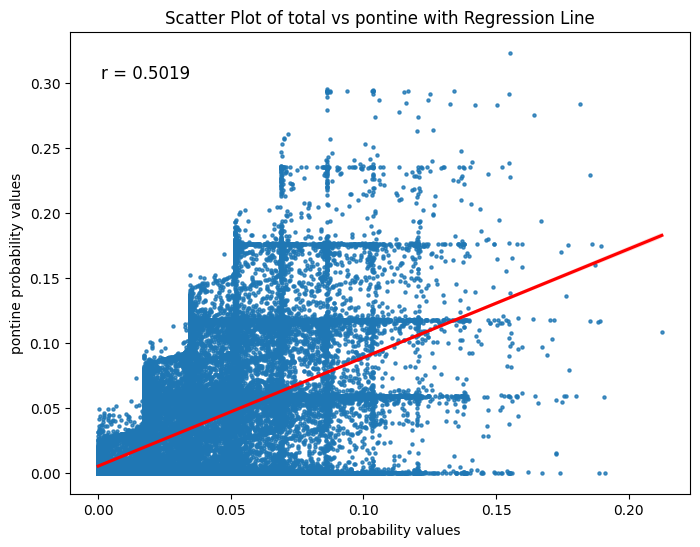

In [4]:
#regression lines for correlations

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sb.regplot(x=pmap_flat, y=pmap_pontine_flat, scatter_kws={"s": 5}, line_kws={"color": "red"})

# Labels and title
plt.xlabel("total probability values")
plt.ylabel("pontine probability values")
plt.title("Scatter Plot of total vs pontine with Regression Line")

# Display the correlation in the title
corr, _ = stats.pearsonr(pmap_flat, pmap_pontine_flat)
plt.annotate(f"r = {corr:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color="black")

plt.show()
